In [1]:
import torchvision
import torch
from torchvision import transforms
from tqdm.auto import tqdm
import random
import numpy as np
from models import vgg,layers
from torchvision.utils import _log_api_usage_once

def manual_seed(seed):
    np.random.seed(seed) #1
    random.seed(seed) #2
    torch.manual_seed(seed) #3
    torch.cuda.manual_seed(seed) #4.1
    torch.cuda.manual_seed_all(seed) #4.2
    torch.backends.cudnn.benchmark = False #5 
    torch.backends.cudnn.deterministic = True #6

manual_seed(42)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
bias_option = True

pre_vgg16 = vgg.vgg16(bias=bias_option)

In [4]:
print(pre_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

weight parameter 변경하기

In [5]:
checkpoint = torch.load("./checkpoint/vgg16_adam_3e-05_64.pth")
print(checkpoint['model_state_dict'])
pre_vgg16.load_state_dict(checkpoint['model_state_dict'])

OrderedDict([('features.0.weight', tensor([[[[ 0.0088, -0.0178, -0.0959],
          [ 0.1229,  0.0205, -0.0342],
          [ 0.0236,  0.1382,  0.0203]],

         [[-0.0419,  0.0439,  0.0065],
          [-0.1620,  0.0823,  0.0110],
          [-0.0216,  0.0952,  0.0605]],

         [[-0.1239,  0.1539,  0.0574],
          [ 0.1103,  0.0528, -0.1128],
          [ 0.1326, -0.1258, -0.0360]],

         [[-0.1210,  0.0103, -0.1533],
          [-0.0023,  0.1015,  0.0797],
          [-0.1425, -0.1219, -0.0327]]],


        [[[-0.1381, -0.0145, -0.1343],
          [-0.1463, -0.1411,  0.0838],
          [ 0.0225, -0.0231,  0.1605]],

         [[ 0.0207,  0.0834, -0.0976],
          [-0.0444, -0.1356, -0.1069],
          [-0.1590, -0.0449,  0.1114]],

         [[ 0.0404,  0.0889,  0.0159],
          [-0.0699,  0.1607, -0.0762],
          [ 0.0506, -0.1206,  0.0825]],

         [[ 0.1037,  0.0541, -0.0952],
          [-0.1022, -0.0776,  0.0323],
          [ 0.0259,  0.0098,  0.1579]]],


        [

<All keys matched successfully>

Parameter overwrite

In [6]:
# with torch.no_grad():
#     pre_weight = pre_vgg16.features[0].weight.data
#     print(pre_weight.shape, type(pre_weight))
#     zero_tensor = torch.zeros((64,1,3,3))
#     new_weight = torch.concat([pre_weight, zero_tensor], dim=1)
#     print(new_weight.shape)
#     new_parameter = torch.nn.Parameter(new_weight)
#     print(new_parameter.shape)
#     new_layer = torch.nn.Conv2d(4,64,3,1,1)
#     new_layer.weight = new_parameter
#     pre_vgg16.features[0] = new_layer
#     print(pre_vgg16.features[0].weight.data.shape)
#     print(pre_vgg16)

pre_vgg와 Float,Int model 구조 확인

In [7]:
for name, module in pre_vgg16.named_modules():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        # print(type(module))
        print(name)
        # print(module.weight().int_repr())

print("----------------------------------------------------------")
int_model = vgg.int_vgg16(bias=bias_option)
for name, module in int_model.named_modules():
    if isinstance(module, layers.IntConv2d) or isinstance(module, layers.IntLinear):
        # print(type(module))
        print(name)
        # print(module.weight().int_repr())

features.0
features.2
features.5
features.7
features.10
features.12
features.14
features.17
features.19
features.21
features.24
features.26
features.28
classifier.0
classifier.3
classifier.6
----------------------------------------------------------
features.0
features.2
features.5
features.7
features.10
features.12
features.14
features.17
features.19
features.21
features.24
features.26
features.28
classifier.0
classifier.2
classifier.4


In [8]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomCrop(224,padding=16),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std= (0.2675, 0.2565, 0.2761)),
])

test_transform = transforms.Compose([
     transforms.Resize((224,224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std= (0.2675, 0.2565, 0.2761)),
])

# train_data = torchvision.datasets.CIFAR100(root="./dataset", train=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
#                                           shuffle=True,pin_memory=True,num_workers=4)
val_data = torchvision.datasets.CIFAR100(root="./dataset", train=False, transform=test_transform)
# val_loader = torch.utils.data.DataLoader(val_data, batch_size=32,
#                                           shuffle=False,pin_memory=True,num_workers=4)
# val_data = torchvision.datasets.ImageNet(root="./dataset/ImageNet", split='val', transform=test_transform)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32,
                                          shuffle=False,pin_memory=True,num_workers=4)


In [9]:
next_data = next(iter(val_loader))[0]
print(next_data.shape, next_data.max(), next_data.min())
imgs = torch.cat([next_data, torch.zeros((next_data.size(0),1,224,224))], dim=1)
print(imgs.shape)

torch.Size([32, 3, 224, 224]) tensor(1.) tensor(0.)
torch.Size([32, 4, 224, 224])


In [10]:
pre_vgg16.eval()
pre_vgg16.cuda()
def validate(model, test_loader, num_calib=None, cpu_device=False):
    model.eval()
    val_acc = 0
    with torch.no_grad():
        for i,data in enumerate(tqdm(test_loader,leave=True)):
            imgs = torch.cat([data[0], torch.zeros((data[0].size(0),1,224,224))], 1)
            if cpu_device:
                target = data[1]
            else:
                imgs, target = imgs.to(device), data[1].to(device)
            output = model(imgs)

            _, preds = torch.max(output.data, 1)
            val_acc += (preds==target).sum().item()
            if num_calib and (i > num_calib):
                break

    val_acc = 100. * val_acc/len(test_loader.dataset)

    return val_acc
start_acc = validate(pre_vgg16, val_loader)
pre_vgg16.to('cpu')
print(f"START  ACC {start_acc:.2f}")

100%|██████████| 313/313 [00:36<00:00,  8.67it/s]


START  ACC 39.12


Float 모델에 실험 해보기 NHWC

In [11]:
float_model = vgg.float_vgg16(bias=bias_option) 

# bias 가 없는 모델 사용함
with torch.no_grad():
    conv_list = [0,2,5,7,10,12,14,17,19,21,24,26,28]

    for i in conv_list:
        pre_weight = pre_vgg16.features[i].weight.data.contiguous()
        print(f"{i} \nconv pre_weight shape : {pre_weight.shape} {pre_weight.stride()}")
        # convert_channel = pre_weight.to(memory_format=torch.channels_last)
        # print(f"convert channel last {convert_channel.shape} {convert_channel.stride()}")

        # convert_channel = convert_channel.permute(0,2,3,1).to(memory_format=torch.channels_last)
        # print(f"{convert_channel.shape} {convert_channel.stride()}")

        float_model.features[i].weight = pre_weight.permute(0,2,3,1).contiguous()
        print(f"after_weight shape : {float_model.features[i].weight.shape}, {(float_model.features[i].weight.stride())}")
        if bias_option:
            pre_bias = pre_vgg16.features[i].bias.data.contiguous()
            print(f"bias shape : {pre_vgg16.features[i].bias.shape}")
            
            float_model.features[i].bias = pre_bias.contiguous()
            print(torch.equal(pre_weight, float_model.features[i].weight.permute(0,3,1,2)))
        # print()

    linear_list = [(0,0), (3,2), (6,4)]

    for p_i, int_i in linear_list:
        pre_weight = pre_vgg16.classifier[p_i].weight.data
        print(f"{p_i} \nlinaer pre_weight shape : {pre_weight.shape} {pre_weight.stride()}")
        
        float_model.classifier[int_i].weight = pre_weight.permute(1,0).contiguous()
        print(f"after_weight shape : {float_model.classifier[int_i].weight.shape} {float_model.classifier[int_i].weight.stride()}")
        
        if bias_option:
            pre_bias = pre_vgg16.classifier[p_i].bias.data
            print(f"linaer pre_bias shape : {pre_bias.shape} {pre_bias.stride()}")
            
            float_model.classifier[int_i].bias = pre_bias.contiguous()
            print(f"after_bias shape : {float_model.classifier[int_i].bias.shape} {float_model.classifier[int_i].bias.stride()}\n")


0 
conv pre_weight shape : torch.Size([64, 4, 3, 3]) (36, 9, 3, 1)
after_weight shape : torch.Size([64, 3, 3, 4]), (36, 12, 4, 1)
bias shape : torch.Size([64])
True
2 
conv pre_weight shape : torch.Size([64, 64, 3, 3]) (576, 9, 3, 1)
after_weight shape : torch.Size([64, 3, 3, 64]), (576, 192, 64, 1)
bias shape : torch.Size([64])
True
5 
conv pre_weight shape : torch.Size([128, 64, 3, 3]) (576, 9, 3, 1)
after_weight shape : torch.Size([128, 3, 3, 64]), (576, 192, 64, 1)
bias shape : torch.Size([128])
True
7 
conv pre_weight shape : torch.Size([128, 128, 3, 3]) (1152, 9, 3, 1)
after_weight shape : torch.Size([128, 3, 3, 128]), (1152, 384, 128, 1)
bias shape : torch.Size([128])
True
10 
conv pre_weight shape : torch.Size([256, 128, 3, 3]) (1152, 9, 3, 1)
after_weight shape : torch.Size([256, 3, 3, 128]), (1152, 384, 128, 1)
bias shape : torch.Size([256])
True
12 
conv pre_weight shape : torch.Size([256, 256, 3, 3]) (2304, 9, 3, 1)
after_weight shape : torch.Size([256, 3, 3, 256]), (2304, 

In [12]:
float_model.eval()
float_model.cuda()
val_acc = 0
with torch.no_grad():
    for i,data in enumerate(tqdm(val_loader,leave=True)):
        # imgs = torch.tensor(data[0].clone().detach()-128, dtype=torch.int8)
        imgs = torch.cat([data[0], torch.zeros((data[0].size(0),1,224,224))], dim=1)
        imgs = imgs.permute(0,2,3,1)
        imgs = imgs.contiguous()
        imgs, target = imgs.to(device), data[1].to(device)
        
        output = float_model(imgs)
        _, preds = torch.max(output.data, 1)
        val_acc += (preds==target).sum().item()

val_acc = 100. * val_acc/len(val_loader.dataset)
print(f"float model test result : {val_acc:.2f}")

  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:34<00:00,  9.15it/s]

float model test result : 39.14


## Float type weight 를 Integer type으로 변경하기    
MinMax를 사용하여

In [65]:
# bias 가 있는
from torch.ao.quantization.observer import PerChannelMinMaxObserver

int_model = vgg.int_vgg16(bias=bias_option)
count = 0

# 전체 conv_weight의 분포
# 전체 linear weight의 분포

conv_weights = []
linear_weights = []
with torch.no_grad():
    quant_min = -128
    quant_max = 127


    conv_list = [0,2,5,7,10,12,14,17,19,21,24,26,28]
    for i in conv_list:
        observer = PerChannelMinMaxObserver(quant_max=127,quant_min=-128)
    
        pre_weight = pre_vgg16.features[i].weight.data.contiguous()
        conv_weights.append(pre_weight.view(-1).tolist())

        quant_weight = observer(pre_weight)
        # pre_weight랑 quant_weigth랑 차이가 없음
        # print("--------------check diff------------------")
        # print(pre_weight[0])
        # print(quant_weight[0])
        # print("--------------check diff------------------")
        # print(f"quant_weight {quant_weight.shape}")
        scale, zero_tensor = observer.calculate_qparams()

        quant_weight = torch.tensor(quant_weight/scale.view(-1,1,1,1) + zero_tensor.view(-1,1,1,1), dtype=torch.int8)
        
        int_model.features[i].weight = quant_weight.permute(0,2,3,1).contiguous()

        if bias_option:
            pre_bias = pre_vgg16.features[i].bias
            quant_bias = torch.tensor(pre_bias/scale + zero_tensor, dtype=torch.int8)
            int_model.features[i].bias = quant_bias.contiguous()

        if count < 1:
            print(f"{i} \nconv pre_weight shape : {pre_weight.shape} {pre_weight.stride()}")
            print(f"pre_weight {pre_weight}")
            print(f"scale {scale.shape} {scale}, \nzero_tensor {zero_tensor.shape} {zero_tensor}")
            print(f"quant weight {quant_weight}")
            print(quant_weight.min(), quant_weight.max())
            print(f"pre bias \t {pre_bias}")
            print(f"quant_bias \t{quant_bias}")
        count += 1
    count = 0 

    linear_list = [(0,0), (3,2), (6,4)]

    for p_i, int_i in linear_list:
        observer = PerChannelMinMaxObserver(quant_max=127,quant_min=-128)

        pre_weight = pre_vgg16.classifier[p_i].weight.data.contiguous()
        linear_weights.append(pre_weight.view(-1).tolist())
        print(f"{p_i} \nlinaer pre_weight shape : {pre_weight.shape} {pre_weight.stride()}")


        quant_weight = observer(pre_weight)
        scale, zero_tensor = observer.calculate_qparams()
        quant_weight = torch.tensor(quant_weight/scale.view(-1,1) + zero_tensor.view(-1,1), dtype=torch.int8)

        print(quant_weight.min(), quant_weight.max())

        int_model.classifier[int_i].weight = quant_weight.permute(1,0).contiguous()
        if bias_option:
            pre_bias = pre_vgg16.classifier[p_i].bias
            quant_bias = torch.tensor(pre_bias/scale + zero_tensor, dtype=torch.int8)
            int_model.classifier[int_i].bias = quant_bias.contiguous()


    torch.save({
        'model':int_model,
        'model_state_dict':int_model.state_dict(),
        'pre_acc': val_acc
    }, f"./checkpoint/minmax_bias.pth")


/tmp/ipykernel_1683340/1006822924.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quant_weight = torch.tensor(quant_weight/scale.view(-1,1,1,1) + zero_tensor.view(-1,1,1,1), dtype=torch.int8)
/tmp/ipykernel_1683340/1006822924.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quant_bias = torch.tensor(pre_bias/scale + zero_tensor, dtype=torch.int8)


0 
conv pre_weight shape : torch.Size([64, 4, 3, 3]) (36, 9, 3, 1)
pre_weight tensor([[[[ 0.0088, -0.0178, -0.0959],
          [ 0.1229,  0.0205, -0.0342],
          [ 0.0236,  0.1382,  0.0203]],

         [[-0.0419,  0.0439,  0.0065],
          [-0.1620,  0.0823,  0.0110],
          [-0.0216,  0.0952,  0.0605]],

         [[-0.1239,  0.1539,  0.0574],
          [ 0.1103,  0.0528, -0.1128],
          [ 0.1326, -0.1258, -0.0360]],

         [[-0.1210,  0.0103, -0.1533],
          [-0.0023,  0.1015,  0.0797],
          [-0.1425, -0.1219, -0.0327]]],


        [[[-0.1381, -0.0145, -0.1343],
          [-0.1463, -0.1411,  0.0838],
          [ 0.0225, -0.0231,  0.1605]],

         [[ 0.0207,  0.0834, -0.0976],
          [-0.0444, -0.1356, -0.1069],
          [-0.1590, -0.0449,  0.1114]],

         [[ 0.0404,  0.0889,  0.0159],
          [-0.0699,  0.1607, -0.0762],
          [ 0.0506, -0.1206,  0.0825]],

         [[ 0.1037,  0.0541, -0.0952],
          [-0.1022, -0.0776,  0.0323],
         

/tmp/ipykernel_1683340/1006822924.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quant_weight = torch.tensor(quant_weight/scale.view(-1,1) + zero_tensor.view(-1,1), dtype=torch.int8)
/tmp/ipykernel_1683340/1006822924.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quant_bias = torch.tensor(pre_bias/scale + zero_tensor, dtype=torch.int8)


tensor(-128, dtype=torch.int8) tensor(127, dtype=torch.int8)
3 
linaer pre_weight shape : torch.Size([4096, 4096]) (4096, 1)
tensor(-128, dtype=torch.int8) tensor(127, dtype=torch.int8)
6 
linaer pre_weight shape : torch.Size([100, 4096]) (4096, 1)
tensor(-128, dtype=torch.int8) tensor(127, dtype=torch.int8)


## floating type으로 학습한 모델을 가지고 quantization 하기   
위에 꺼랑 비교해보기

In [14]:
class Quantized(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        _log_api_usage_once(self)
        
        self.model = model
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.model(x)
        x = self.dequant(x)
        return x

    def fuse_model(self):
        pass


In [15]:
from torch.ao.quantization import observer
from torch.ao.quantization.backend_config import BackendConfig, BackendPatternConfig, DTypeConfig, DTypeWithConstraints
quant_model = Quantized(pre_vgg16)


quant_model.cpu()
quant_model.eval()
backend = 'fbgemm'
qconfig = torch.ao.quantization.get_default_qconfig(backend)

# new_qconfig = torch.ao.quantization.QConfig(
#     activation=observer.HistogramObserver.with_args(reduce_range=True),
#     weight=observer.PerChannelMinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_channel_symmetric),
#     bias=observer.MinMaxObserver.with_args(dtype=torch.qint32)  # Bias를 qint32로 설정
# )
print(f"q config :\n{qconfig}")

# new_qconfig_dict = qconfig._asdict()
# new_qconfig_dict['bias'] = new_qconfig.bias
# print(new_qconfig)
# new_qconfig = torch.

quant_model.qconfig = qconfig
# print(f"defualt qconfig ; {quant_model.qconfig}")
torch.backends.quantized.engine = backend
print(torch.backends.quantized.engine)
model_static_quantized = torch.ao.quantization.prepare(quant_model, inplace = False)

q config :
QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})
fbgemm


/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [16]:
# calibration
validate(model_static_quantized,val_loader,10,cpu_device=True)

# make quantized model
torch.ao.quantization.convert(model_static_quantized, inplace = True) 

  4%|▎         | 11/313 [02:07<58:29, 11.62s/it]


Quantized(
  (model): VGG(
    (features): Sequential(
      (0): QuantizedConv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.018216310068964958, zero_point=78, padding=(1, 1))
      (1): ReLU()
      (2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.022390827536582947, zero_point=68, padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): QuantizedConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.036442290991544724, zero_point=65, padding=(1, 1))
      (6): ReLU()
      (7): QuantizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.06950325518846512, zero_point=77, padding=(1, 1))
      (8): ReLU()
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): QuantizedConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.10467969626188278, zero_point=76, padding=(1, 1))
      (11): ReLU()
      (12): QuantizedConv2d(256, 2

In [17]:
# torch.save({
#     'model':model_static_quantized,
#     'model_state_dict' : model_static_quantized.state_dict(),
#     },"./checkpoint/static_quant_fbegmm_test.pth")

# # # torch.jit.save(torch.jit.script(model_static_quantized),"./checkpoint/static_quant_fbegmm_test.pth")
# # model_static_quantized = torch.jit.load("./checkpoint/static_quant_fbegmm_test.pth")
# # print(model_static_quantized)

In [18]:
test_acc = validate(model_static_quantized, val_loader, cpu_device=True)
print(f"test result : {test_acc:.2f}")

  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [12:16<00:00,  2.35s/it]

test result : 36.98


In [39]:
torch_static_conv_scale = []
torch_static_conv_zero = []

for name, module in model_static_quantized.named_modules():
    if isinstance(module, torch.ao.nn.quantized.modules.conv.Conv2d) or isinstance(module, torch.ao.nn.quantized.modules.linear.Linear):
        # print(type(module))
        print(name)
        # print(module.weight().int_repr().permute(0,2,3,1))
        print(module.weight().int_repr().min())
        print(module.weight().int_repr().max())

model.features.0
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
model.features.2
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
model.features.5
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
model.features.7
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
model.features.10
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
model.features.12
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
model.features.14
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
model.features.17
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
model.features.19
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
model.features.21
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
model.features.24
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
model.features.26
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
model.features.28
tensor(-128, dtype=torch.int8)
tensor(

In [ ]:
# int_model = vgg.int_vgg16()
# for name, module in int_model.named_modules():
#     if isinstance(module, layers.IntConv2d) or isinstance(module, layers.IntLinear):
#         # print(type(module))
#         print(name)
#         # print(module.weight().int_repr())

torch quantization으로 만든 Intger weight를 Int_model에 옮기기

In [ ]:
# with torch.no_grad():
#     conv_list = [0,2,5,7,10,12,14,17,19,21,24,26,28]

#     for i in conv_list:
#         pre_weight = model_static_quantized.model.features[i].weight().int_repr()
#         print(f"{i} conv pre_weight shape : {pre_weight.shape}")

#         int_model.features[i].weight = pre_weight.permute(0,2,3,1).contiguous()
#         print(f"after_weight shape : {int_model.features[i].weight.shape}, {(int_model.features[i].weight.stride())}")
#         # int_model.features[i].bias = pre_bias.contiguous()
#     linear_list = [(0,0), (3,2), (6,4)]

#     for p_i, int_i in linear_list:
#         pre_weight = model_static_quantized.model.classifier[p_i].weight().int_repr()
#         print(f"{p_i} linaer pre_weight shape : {pre_weight.shape}")
        
#         int_model.classifier[int_i].weight = pre_weight.transpose(1,0).contiguous()
#         print(f"after_weight shape : {int_model.classifier[int_i].weight.shape}")

# torch.save({
#     'model':int_model,
#     'model_state_dict':int_model.state_dict(),
#     'pre_acc': val_acc
# }, f"./checkpoint/int_model_no_bias.pth")


In [ ]:
int_model = vgg.int_vgg16(bias=bias_option)

int_model.load_state_dict(torch.load('./checkpoint/minmax_bias.pth')['model_state_dict'])

<All keys matched successfully>

Intmodel quantization ?

In [40]:
for name, module in int_model.named_modules():
    if isinstance(module, layers.IntConv2d) or isinstance(module, layers.IntLinear):
        # print(type(module))
        print(name)
        # print(module.weight)
        print(module.weight.min())
        print(module.weight.max())

features.0
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
features.2
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
features.5
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
features.7
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
features.10
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
features.12
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
features.14
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
features.17
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
features.19
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
features.21
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
features.24
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
features.26
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
features.28
tensor(-128, dtype=torch.int8)
tensor(127, dtype=torch.int8)
classifier.0
tensor(-128, dtype=torch.int8)
tensor(127,

In [ ]:
int_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
    # transforms.ConvertImageDtype(torch.int8)
    # NHWC 로 해야한다.
])

val_data = torchvision.datasets.CIFAR100(root="./dataset", train=False, transform=int_transform)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False,pin_memory=True,num_workers=4)
next_data = next(iter(val_loader))[0]
print(next_data.shape, next_data.max(), next_data.min())



torch.Size([32, 3, 224, 224]) tensor(1.) tensor(0.)


In [ ]:
from torch.ao.quantization.observer import HistogramObserver

activation_observer = HistogramObserver(quant_max=127, quant_min=-128)
quant_data = activation_observer(next_data)

scale, zero_tensor = activation_observer.calculate_qparams()
# print(next_data[0])
print(f"scale shape {scale.shape}, zero_tensor shape {zero_tensor.shape}")
# print(scale)
# print(quant_data[0])
quant_data = torch.tensor(next_data/scale + zero_tensor, dtype=torch.int8)
print(quant_data)
# quantized_data = torch.quantize_per_tensor(next_data, scale=scale, zero_point=zero_tensor, dtype=torch.quint8)

scale shape torch.Size([1]), zero_tensor shape torch.Size([1])
tensor([[[[ 71,  71,  71,  ...,  96,  96,  96],
          [ 71,  71,  71,  ...,  96,  96,  96],
          [ 71,  71,  71,  ...,  96,  96,  96],
          ...,
          [-47, -47, -47,  ...,  48,  48,  48],
          [-47, -47, -47,  ...,  48,  48,  48],
          [-47, -47, -47,  ...,  48,  48,  48]],

         [[ 87,  87,  87,  ..., 106, 106, 106],
          [ 87,  87,  87,  ..., 106, 106, 106],
          [ 87,  87,  87,  ..., 106, 106, 106],
          ...,
          [-42, -42, -42,  ...,  36,  36,  36],
          [-42, -42, -42,  ...,  36,  36,  36],
          [-42, -42, -42,  ...,  36,  36,  36]],

         [[121, 121, 121,  ..., 124, 124, 124],
          [121, 121, 121,  ..., 124, 124, 124],
          [121, 121, 121,  ..., 124, 124, 124],
          ...,
          [ -9,  -9,  -9,  ...,  55,  55,  55],
          [ -9,  -9,  -9,  ...,  55,  55,  55],
          [ -9,  -9,  -9,  ...,  55,  55,  55]]],


        [[[-14, -14,

/tmp/ipykernel_1632564/1080809384.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quant_data = torch.tensor(next_data/scale + zero_tensor, dtype=torch.int8)


In [ ]:
int_model.eval()
int_model.cuda()
val_acc = 0
with torch.no_grad():
    for i,data in enumerate(tqdm(val_loader,leave=True)):
        # imgs = torch.tensor(data[0].clone().detach()*256-128, dtype=torch.int8)
        # imgs = torch.tensor(data[0].clone().detach(), dtype=torch.int8)
        imgs = torch.tensor(data[0].clone().detach()/0.0079, dtype=torch.int8)
        # print(f"{imgs.shape} {imgs.max()} {imgs.min()}\n{imgs[0]}")
        # break
        imgs = imgs.permute(0,2,3,1)
        imgs = torch.cat([imgs, torch.zeros((data[0].size(0),224,224,1), dtype=torch.int8)], dim=-1)
        imgs, target = imgs.to(device), data[1].to(device)
        imgs = imgs.contiguous()
        output = int_model(imgs)
        _, preds = torch.max(output.data, 1)
        val_acc += (preds==target).sum().item()

val_acc = 100. * val_acc/len(val_loader.dataset)
print(f"test result : {val_acc:.2f}")


  0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_1632564/161881618.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(data[0].clone().detach()*256-128, dtype=torch.int8)
/workspace/int_infer/models/layers.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x/scale + zero_tensor, dtype=torch.int8)
100%|██████████| 313/313 [22:08<00:00,  4.25s/it]

test result : 0.85


In [67]:
print(len(conv_weights))

13
[0.008759161457419395, -0.0178440622985363, -0.09593403339385986, 0.12288951873779297, 0.020521938800811768, -0.03415032476186752, 0.02355372905731201, 0.13821575045585632, 0.020333409309387207, -0.041939061135053635, 0.04385018348693848, 0.0065469942055642605, -0.1620417684316635, 0.082347571849823, 0.011041621677577496, -0.021648269146680832, 0.0951804518699646, 0.06051504611968994, -0.12392546981573105, 0.15390729904174805, 0.05739015340805054, 0.11025568097829819, 0.05284913629293442, -0.11278872191905975, 0.13263504207134247, -0.12580464780330658, -0.03596339747309685, -0.12103458493947983, 0.010289093479514122, -0.15330931544303894, -0.0022844872437417507, 0.10146620124578476, 0.07966969907283783, -0.14248761534690857, -0.12187262624502182, -0.03265492245554924, -0.13812756538391113, -0.014480113983154297, -0.13433854281902313, -0.1463301181793213, -0.1411084234714508, 0.0837610587477684, 0.02245241403579712, -0.023088812828063965, 0.16052953898906708, 0.020677050575613976, 0.

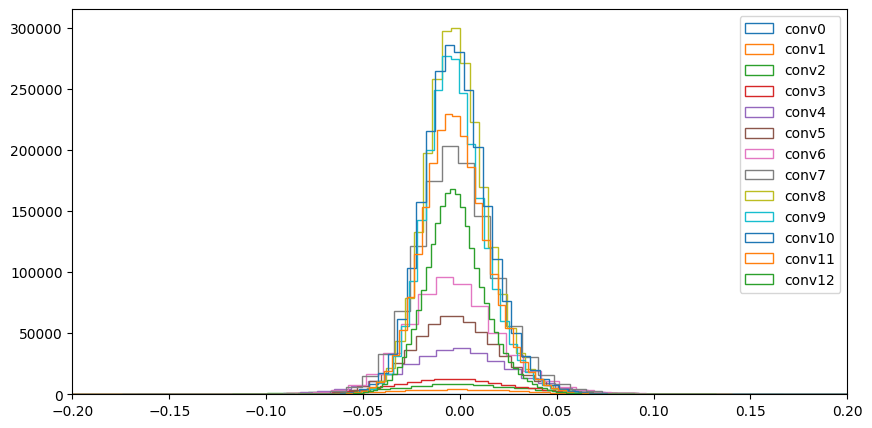

In [ ]:
import matplotlib.pyplot as plt
max_val = 0
min_val = -10000
plt.figure(figsize=(10,5))
for i in [0,2,3,11,12]:
    plt.hist(conv_weights[i], bins=100, histtype='step', label=f"conv{i}")
    max_val = max(max_val, conv_weights[i].max())
    min_val = min(min_val, conv_weights[i].min())
plt.xlim(-0.2,0.2)
plt.legend()
plt.show()

In [79]:
plt.figure(figsize=(10,5))
max_val = 0
min_val = -10000
for i in range(len(linear_weights),0,-1):
    plt.hist(linear_weights[i], bins=100, histtype='step', label=f"linear{i}")
    max_val = max(max_val, linear_weights[i].max())
    min_val = min(min_val, linear_weights[i].min())
    break
plt.legend()
plt.show()